In [328]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [329]:
#from source.utils import *
from source.preprocess import *
from source.model_utils import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm

In [330]:
path = "../../Desktop/DLC_social_1/"
path2 = "../../Desktop/DLC_social_2/"

# Set up and design the project

In [331]:
with open('{}DLC_social_1_exp_conditions.pickle'.format(path), 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [332]:
Treatment_dict["WT+NS"]

['Test 6DLC',
 'Test 15DLC',
 'Test 24DLC',
 'Test 29DLC',
 'Test 38DLC',
 'Test 47DLC',
 'Day2Test8DLC',
 'Day2Test13DLC',
 'Day2Test22DLC',
 'Day2Test31DLC',
 'Day2Test40DLC']

In [333]:
#Which angles to compute?
bp_dict = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [334]:
%%time
DLC_social_1 = project(path=path,#Path where to find the required files
                   smooth_alpha=0.5,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   subset_condition="B",
                   video_format='.mp4',
                   table_format='.h5',
                   exp_conditions=Treatment_dict)

CPU times: user 2.65 s, sys: 853 ms, total: 3.5 s
Wall time: 1.11 s


In [335]:
%%time
DLC_social_2 = project(path=path2,#Path where to find the required files
                   smooth_alpha=0.5,                    #Alpha value for exponentially weighted smoothing
                   distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                              'B_Right_flank','B_Tail_base'],
                   ego=False,
                   angles=True,
                   connectivity=bp_dict,
                   arena='circular',                  #Type of arena used in the experiments
                   arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                   subset_condition="B",
                   video_format='.mp4',
                   table_format='.h5')

CPU times: user 6.57 s, sys: 1.11 s, total: 7.68 s
Wall time: 1.6 s


# Run project

In [336]:
%%time
DLC_social_1_coords = DLC_social_1.run(verbose=True)
print(DLC_social_1_coords)
type(DLC_social_1_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
Coordinates of 47 videos across 4 conditions
CPU times: user 4.36 s, sys: 413 ms, total: 4.77 s
Wall time: 4.79 s


source.preprocess.coordinates

In [337]:
%%time
DLC_social_2_coords = DLC_social_2.run(verbose=True)
print(DLC_social_2_coords)
type(DLC_social_2_coords)

Loading trajectories...
Smoothing trajectories...
Computing distances...
Computing angles...
Done!
DLC analysis of 31 videos
CPU times: user 3.17 s, sys: 293 ms, total: 3.46 s
Wall time: 3.63 s


source.preprocess.coordinates

# Generate coords

In [338]:
%%time
ptest = DLC_social_1_coords.get_coords(center="B_Center", polar=False, speed=0, length='00:10:00')
ptest._type

ptest2 = DLC_social_2_coords.get_coords(center="B_Center", polar=False, speed=0, length='00:10:00')
ptest2._type

CPU times: user 1.13 s, sys: 53 ms, total: 1.18 s
Wall time: 1.19 s


'coords'

In [339]:
ptest['Test 13DLC'].columns.levels

FrozenList([['B_Center', 'B_Left_ear', 'B_Left_flank', 'B_Nose', 'B_Right_ear', 'B_Right_flank', 'B_Tail_base'], ['x', 'y']])

In [340]:
%%time
dtest = DLC_social_1_coords.get_distances(speed=0, length='00:10:00')
dtest._type

dtest2 = DLC_social_2_coords.get_distances(speed=0, length='00:10:00')
dtest2._type

CPU times: user 78.9 ms, sys: 42.7 ms, total: 122 ms
Wall time: 121 ms


'dists'

In [341]:
%%time
atest = DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest._type

atest2 = DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00')
atest2._type

CPU times: user 213 ms, sys: 131 ms, total: 345 ms
Wall time: 345 ms


'angles'

# Visualization playground

In [342]:
# ptest.plot_heatmaps(['B_Nose'], i=2)

In [ ]:
ptest['Day2Test13DLC']['B_Nose'].iloc[:5000]

In [ ]:
#Plot animation of trajectory over time with different smoothings
# plt.plot(ptestb['Day2Test13DLC']['B_Nose'].iloc[:50]['x'],
#          ptestb['Day2Test13DLC']['B_Nose'].iloc[:50]['y'], label='alpha=0.95')

# plt.plot(ptestd['Day2Test13DLC']['B_Nose'].iloc[:50]['x'],
#          ptestd['Day2Test13DLC']['B_Nose'].iloc[:50]['y'], label='alpha=0.65')

# plt.xlabel('x')
# plt.ylabel('y')
# plt.title('Mouse Center Trajectory using different exponential smoothings')
# plt.legend()
# plt.show()

# Dimensionality reduction playground

In [17]:
#pca = ptest.pca(4, 1000)

In [18]:
#plt.scatter(*pca[0].T)
#plt.show()

# Preprocessing playground

In [19]:
mtest = merge_tables(
                      DLC_social_1_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose')
                      #DLC_social_1_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_1_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [20]:
mtest2 = merge_tables(
                      DLC_social_2_coords.get_coords(center="B_Center", polar=False, length='00:10:00', align='B_Nose'),
                      #DLC_social_2_coords.get_distances(speed=0, length='00:10:00'),
                      #DLC_social_2_coords.get_angles(degrees=True, speed=0, length='00:10:00'),
                    )

In [21]:
pttest = mtest.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,
                          shift=0, scale="standard", align=True, shuffle=True)
pttest.shape

(70504, 11, 12)

In [22]:
pttest2 = mtest2.preprocess(window_size=11, window_step=1, filter=None, sigma=55,
                            shift=0, scale="standard", align=True, shuffle=False)
pttest2.shape

(465021, 11, 12)

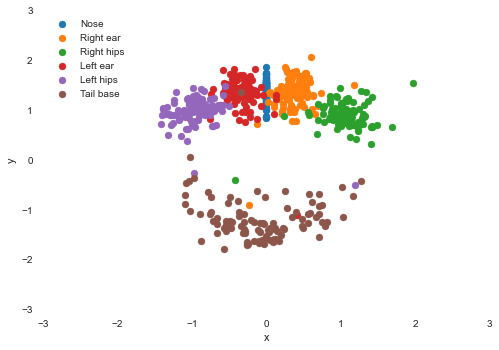

In [23]:
n = 100

plt.scatter(pttest[:n,5,0], pttest[:n,5,1], label='Nose')
plt.scatter(pttest[:n,5,2], pttest[:n,5,3], label='Right ear')
plt.scatter(pttest[:n,5,4], pttest[:n,5,5], label='Right hips')
plt.scatter(pttest[:n,5,6], pttest[:n,5,7], label='Left ear')
plt.scatter(pttest[:n,5,8], pttest[:n,5,9], label='Left hips')
plt.scatter(pttest[:n,5,10], pttest[:n,5,11], label='Tail base')

plt.xlim(-3,3)
plt.ylim(-3,3)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

# Trained models playground

### Seq 2 seq Variational Auto Encoder

In [24]:
from datetime import datetime
import tensorflow.keras as k
import tensorflow as tf

In [25]:
NAME = 'Baseline_AE_512_wu10_slide10_gauss_fullval'
log_dir = os.path.abspath(
    "logs/fit/{}_{}".format(NAME, datetime.now().strftime("%Y%m%d-%H%M%S"))
)
tensorboard_callback = k.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [26]:
from source.models import SEQ_2_SEQ_AE, SEQ_2_SEQ_GMVAE

In [27]:
encoder, decoder, ae = SEQ_2_SEQ_AE(pttest.shape).build()
ae.build(pttest.shape)

In [28]:
ae.summary()

Model: "SEQ_2_SEQ_AE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
SEQ_2_SEQ_Encoder (Sequentia (None, 16)                1769680   
_________________________________________________________________
SEQ_2_SEQ_Decoder (Sequentia multiple                  2678172   
Total params: 4,405,660
Trainable params: 4,401,308
Non-trainable params: 4,352
_________________________________________________________________


In [29]:
%%time

tf.keras.backend.clear_session()

encoder, generator, grouper, gmvaep, kl_warmup_callback, mmd_warmup_callback = SEQ_2_SEQ_GMVAE(pttest.shape,
                                                                               loss='ELBO',
                                                                               number_of_components=6,
                                                                               kl_warmup_epochs=10,
                                                                               mmd_warmup_epochs=10,
                                                                               encoding=16,
                                                                               predictor=False).build()
# gmvaep.build(pttest.shape)

CPU times: user 4.34 s, sys: 65.5 ms, total: 4.4 s
Wall time: 4.31 s


In [30]:
import tensorflow as tf
from tensorflow import keras as keras
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)
        

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses


def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [31]:
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

10/10 [==============================] - 7s 702ms/step - loss: 1308991.3750 - mae: 2.9113 - -weight_entropy: -1.1421 - kl_divergence: 108.4410 - kl_rate: 1.0000 - dead_neurons: 0.0000e+00


(9.999999747378752e-06, 2.5118863582611084, 72256.6015625, 112896.31696428572)

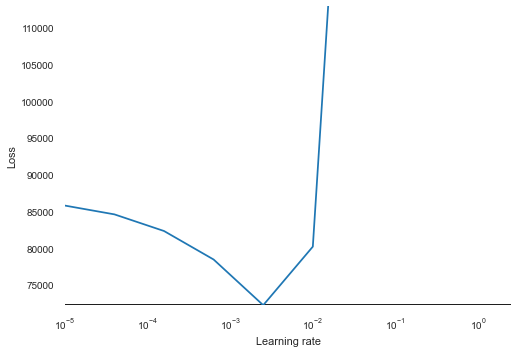

In [32]:
batch_size = 512
rates, losses = find_learning_rate(gmvaep, pttest[:512*10], pttest[:512*10], epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

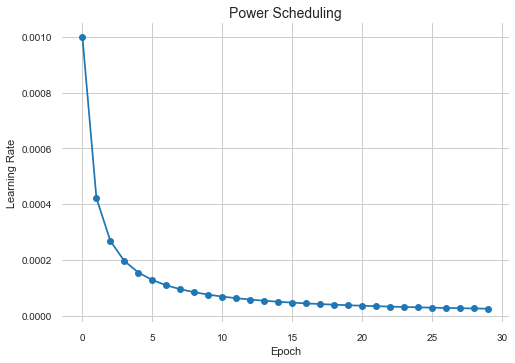

In [33]:
# Power scheduling visualization
learning_rate = 1e-3
decay = 1e-2
batch_size = 512
n_steps_per_epoch =  70504 // batch_size
epochs = np.arange(30)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
#plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

## Encoding interpretation playground

In [ ]:
import umap
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import plotly.express as px

In [280]:
data = pttest2
samples = 15000
montecarlo = 10

In [281]:
weights = "GMVAE_components=6_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200730-174416_final_weights.h5"

gmvaep.load_weights(weights)

if montecarlo:
    clusts = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
    clusters = clusts.mean(axis=0)
    clusters = np.argmax(clusters, axis=1)
    
else:
    clusters = grouper(data[:samples], training=False)

    
    clusters = np.argmax(clusters, axis=1)

In [282]:
def plot_encodings(data, samples, n, clusters, threshold):
    
    reducer  = LinearDiscriminantAnalysis(n_components=n)
    clusters = clusters[:, :samples]
    filter   = np.max(np.mean(clusters, axis=0), axis=1) > threshold
    
    print("{}/{} samples used ({}%); confidence threshold={}".format(sum(filter),
                                                                     samples,
                                                                     sum(filter)/samples*100,
                                                                     threshold))
    
    clusters = np.argmax(np.mean(clusters, axis=0), axis=1)[filter]
    rep = reducer.fit_transform(encoder.predict(data[:samples][filter]), clusters)

    if n == 2:
        df = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter(data_frame=df, x="encoding-1", y="encoding-2",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)


    elif n == 3:
        df3d = pd.DataFrame({"encoding-1":rep[:,0],"encoding-2":rep[:,1],"encoding-3":rep[:,2],
                         "clusters":["A"+str(i) for i in clusters]})

        enc = px.scatter_3d(data_frame=df3d, x="encoding-1", y="encoding-2", z="encoding-3",
                           color="clusters", width=600, height=600,
                           color_discrete_sequence=px.colors.qualitative.T10)

    return enc

plot_encodings(data, 15000, 2, clusts, 0.85)

2435/15000 samples used (16.233333333333334%); confidence threshold=0.85


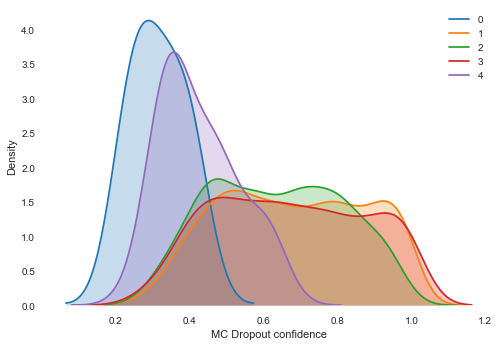

In [136]:
# Confidence distribution per cluster
for cl in range(5):
    cl_select = np.argmax(np.mean(clusts, axis=0), axis=1) == cl
    dt = np.mean(clusts[:,cl_select,cl], axis=0)
    sns.kdeplot(dt, shade=True, label=cl)
    

plt.xlabel('MC Dropout confidence')
plt.ylabel('Density')

plt.show()

In [81]:
def animated_cluster_heatmap(data, clust, clusters, threshold=0.75, samples=False):
    
    if not samples:
        samples = data.shape[0]
    tpoints = data.shape[1]
    bdparts = data.shape[2] // 2
    
    cls = clusters[:,:samples,:]
    filt = np.max(np.mean(cls, axis=0), axis=1) > threshold
    
    cls = np.argmax(np.mean(cls, axis=0), axis=1)[filt]
    clust_series = data[:samples][filt][cls==clust]
    
    rshape = clust_series.reshape(clust_series.shape[0]*clust_series.shape[1],
                                  clust_series.shape[2])
    
    cluster_df = pd.DataFrame()
    cluster_df['x'] = rshape[:,[0,2,4,6,8,10]].flatten(order='F')
    cluster_df['y'] = rshape[:,[1,3,5,7,9,11]].flatten(order='F')
    cluster_df['bpart'] = np.tile(np.repeat(np.arange(bdparts),
                                            clust_series.shape[0]), tpoints)
    cluster_df['frame'] = np.tile(np.repeat(np.arange(tpoints),
                                            clust_series.shape[0]), bdparts)
    
    fig = px.scatter(data_frame=cluster_df, x='x', y='y', animation_frame='frame',
                     width=600, height=600, 
                     color='bpart',color_discrete_sequence=px.colors.qualitative.T10)

    #fig.update_traces(contours_coloring="fill", 
    #                  contours_showlabels = True)
    
    fig.update_xaxes(range=[-3, 3])
    fig.update_yaxes(range=[-3, 3])

    return fig

In [85]:
animated_cluster_heatmap(pttest2, 0, clusts, samples=100)

In [89]:
from collections import Counter
Counter(clusters)

Counter({3: 10940, 1: 1771, 0: 26, 4: 2159, 5: 102, 2: 2})

In [284]:
weights = [i for i in os.listdir() if "0730" in i and ".h5" in i]
mult_clusters = np.zeros([len(weights), samples])
mean_conf = []

for k,i in tqdm(enumerate(sorted(weights))):
    print(i)
    gmvaep.load_weights(i)

    if montecarlo:
        clusters = np.stack([grouper(data[:samples]) for sample in (tqdm(range(montecarlo)))])
        clusters = clusters.mean(axis=0)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    
    else:
        clusters = grouper(data[:samples], training=False)
        mean_conf.append(clusters.max(axis=1))
        clusters = np.argmax(clusters, axis=1)
        
    mult_clusters[k] = clusters

GMVAE_components=6_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200730-165918_final_weights.h5



GMVAE_components=6_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200730-172222_final_weights.h5



GMVAE_components=6_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200730-174416_final_weights.h5



GMVAE_components=6_loss=ELBO_kl_warmup=30_mmd_warmup=30_20200730-180647_final_weights.h5


In [286]:
import pandas as pd
from itertools import combinations
from sklearn.metrics import adjusted_rand_score

In [290]:
mult_clusters = mult_clusters[:-1]

mult_clusters


array([[2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [1., 1., 1., ..., 5., 5., 5.]])

In [302]:
thr = 0.9
ari_dist = []

for i,k in enumerate(combinations(range(len(weights)-1),2)):
    filt = ((mean_conf[k[0]] > thr) & (mean_conf[k[1]]>thr))
    
    ari = adjusted_rand_score(mult_clusters[k[0]][filt],
                              mult_clusters[k[1]][filt])
    
    ari_dist.append(ari)

mean_conf_ = mean_conf_.astype(bool)

In [303]:
ari_dist

[0.729470085423484, 0.6764995437474394, 0.7078158052908745]

In [304]:
random_ari = []
for i in tqdm(range(6)):
    random_ari.append(adjusted_rand_score(np.random.uniform(0,6,50).astype(int),
                                          np.random.uniform(0,6,50).astype(int)))

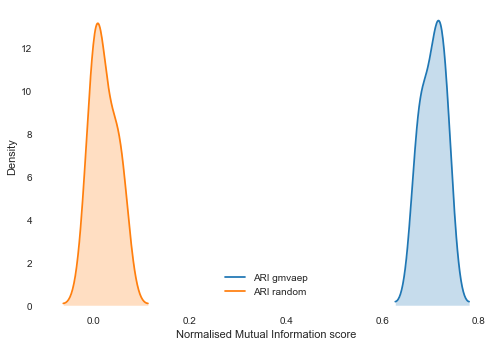

In [305]:
sns.kdeplot(ari_dist, label="ARI gmvaep", shade=True)
sns.kdeplot(random_ari, label="ARI random", shade=True)

plt.xlabel("Normalised Mutual Information score")
plt.ylabel("Density")

plt.legend()
plt.show()

In [105]:
# Reproducibility analyses

In [120]:
[cluster_transition_matrix(clusters, 6)[0][i,i] for i in range(6)]

[0.607, 0.947, 0.25, 0.465, 0.857, 0.663]

In [108]:
#clusters = np.stack([grouper(data[:samples]) for sample in (range(montecarlo))])
#clusters = np.mean(clusters, axis=0)

In [ ]:
sns.distplot(np.max(clusters, axis=1), label="Selected cluster")
sns.distplot(clusters.reshape(clusters.shape[0] * clusters.shape[1]), label="Average confidence")
plt.axvline(1/10)
plt.legend()
plt.show()

# Post clustering analysis playground

In [ ]:
for i in range(5):
    print(Counter(labels[str(i)]))

In [ ]:
adjusted_rand_score(labels[0], labels[3])

In [ ]:
sns.distplot(ari_dist)
plt.xlabel("Adjusted Rand Index")
plt.ylabel("Count")
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [ ]:
from scipy.stats import entropy

In [ ]:
entropy(np.array([0.5,0,0.5,0]))

In [ ]:
tfd.Categorical(np.array([0.5,0.5,0.5,0.5])).entropy()

In [ ]:
pk = np.array([0.5,0,0.5,0])

In [ ]:
np.log(pk)

In [ ]:
np.clip(np.log(pk), 0, 1)

In [ ]:
-np.sum(pk*np.array([-0.69314718,        0, -0.69314718,        0]))

In [ ]:
import tensorflow.keras.backend as K
entropy = K.sum(tf.multiply(pk, tf.where(~tf.math.is_inf(K.log(pk)), K.log(pk), 0)), axis=0)
entropy

In [ ]:
sns.distplot(np.max(clusts, axis=1))
sns.distplot(clusts.reshape(clusts.shape[0] * clusts.shape[1]))
plt.axvline(1/10)
plt.show()

In [ ]:
gauss_means = gmvaep.get_layer(name="dense_4").get_weights()[0][:32]
gauss_variances = tf.keras.activations.softplus(gmvaep.get_layer(name="dense_4").get_weights()[0][32:]).numpy()

In [ ]:
gauss_means.shape == gauss_variances.shape

In [ ]:
k=10
n=100
samples = []
for i in range(k):
    samples.append(np.random.normal(gauss_means[:,i], gauss_variances[:,i], size=(100,32)))

In [ ]:
from scipy.stats import ttest_ind
test_matrix = np.zeros([k,k])
for i in range(k):
    for j in range(k):
        test_matrix[i][j] = np.mean(ttest_ind(samples[i], samples[j], equal_var=False)[1])

In [ ]:
threshold = 0.55
np.sum(test_matrix > threshold)

In [ ]:
# Transition matrix


In [ ]:
Treatment_dict

In [ ]:
# Anomaly detection - the model was trained in the WT - NS mice alone
gmvaep.load_weights("GMVAE_components=10_loss=ELBO_kl_warmup=20_mmd_warmup=5_20200721-043310_final_weights.h5")

In [ ]:
WT_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+NS']}, typ="coords")
WT_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['WT+CSDS']}, typ="coords")
MU_NS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+NS']}, typ="coords")
MU_WS = table_dict({k:v for k,v in mtest2.items() if k in Treatment_dict['NatCre+CSDS']}, typ="coords")

preps = [WT_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         WT_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_NS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True),
         MU_WS.preprocess(window_size=11, window_step=10, filter="gaussian", sigma=55,shift=0, scale="standard", align=True)]

In [ ]:
preds = [gmvaep.predict(i) for i in preps]

In [ ]:
from sklearn.metrics import mean_absolute_error
reconst_error = {k:mean_absolute_error(preps[i].reshape(preps[i].shape[0]*preps[i].shape[1],12).T, 
                                       preds[i].reshape(preds[i].shape[0]*preds[i].shape[1],12).T,
                                       multioutput='raw_values') for i,k in enumerate(Treatment_dict.keys())}

reconst_error

In [ ]:
reconst_df = pd.concat([pd.DataFrame(np.concatenate([np.repeat(k, len(v)).reshape(len(v),1), v.reshape(len(v),1)],axis=1)) for k,v in reconst_error.items()])
reconst_df = reconst_df.astype({0:str,1:float})

In [ ]:
sns.boxplot(data=reconst_df, x=0, y=1, orient='vertical')
plt.ylabel('Mean Absolute Error')
plt.ylim(0,0.35)
plt.show()